# Code summary
-------------------------
This notebook will help you get started by looking into the basic structure of the open data files provided by the ATLAS top-tagging dataset at <https://opendata.cern.ch/record/80030>.

First we will explain the provided opendata files and their format, then we will download some locally (note each one can be as large as 400MB, so we will only download a single file for this notebook), and do some basic inspection of their contents.

## HDF5 format

The data is provided in the HDF5 format, which is a fast and memory-efficienct way to store large datasets. Noteably it is independent of ROOT and integrated very nicely with python, hence it's common usage in machine learning. In the python enviroment it can be easily read with the `h5py` package to load in only queried rows of data in memory in at a time.

## Open-data files

As mentioned on the open data page <https://opendata.cern.ch/record/80030>, several list of files are provided. Each list entry is a tarball containing a single HDF5 file, which stores 

The main two lists are:
- train_nominal: ~92 million jets
- test_nominal: ~10 million jets
which contain an equal portion of fully ATLAS simulated top and QCD jets used for training and testing a neural net algorithm. The top jets are simulated using a BSM $Z'\to t\bar{t}$ process to generate a high $p_T$ jet specturm, while the QCD jets are simulated from multijet production, with a slicing algorithm applied to increase the relative statistics at high $p_T$ as well. These are the main files we will use in these studies

There are also several other filesets provided, which contain different forms of theoretical and experimental systematic effects which can change the neural network performance and introduce an underlying uncertainity in the results. As an example the:
- cer: ~10 million jets with the cluster energy resolution systematic variation active, equal parts signal and background
- ttbar_herwig: ~180 thousand signal jets simulated by  an alternative Herwig production events of Standard Model top-anti top quark pair production.
- string: ~5 million background jets simulated using and alternative Lund string based hadronization model

## Loading the files and taking a peak

The open data files are accessable via https, and the below script should download them locally for you and unzip the tarball. Note these two files sum to 800MB in size. We will use them throughout the notebooks

In [1]:
import sys,os
if not(os.path.isfile("train_nominal_000.h5")):
    if sys.platform=="darwin": #MAC OSX
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz --output train_nominal_000.h5.gz
        !curl https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz --output test_nominal_000.h5.gz
    elif sys.platform == "linux" or sys.platform == "linux2":
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/train_nominal_000.h5.gz
        !wget https://opendata.cern.ch/record/80030/files/assets/atlas/datascience/CERN-EP-2024-159/test_nominal_000.h5.gz
    !gunzip -f train_nominal_000.h5.gz
    !gunzip -f test_nominal_000.h5.gz

Next let's just import some useful packages. The `h5py` will be doing most of the heavy lifting here, and the other two should be familiar to people who use python

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

Okay now opening the HDF5 file with `h5py` is very straightforward and falls in a very python like syntax. Here we load the file into an object named `f`.

In [3]:
infile="train_nominal_000.h5"
f = h5py.File(infile, 'r')
print(f)

<HDF5 file "train_nominal_000.h5" (mode r)>


The python `h5py` package is very useful as it uses a python dictionary-like syntax to access all the information in the file. Let's start with the "Attributes" of the HDF5 file, which is a very useful way to store metadata on the file or the datasets. The attributes can be accessed via `.attrs` and the `.items()` method of this returns full dictionary-like object which we can iterate on.

You can also call a specific atrtibute directly like `f.attrs["num_jets"]`

In [4]:
for key,val in f.attrs.items():
    print("Attribute %s: %s" % (key, val))

Attribute constit: ['fjet_clus_eta' 'fjet_clus_phi' 'fjet_clus_pt' 'fjet_clus_E']
Attribute hl: ['fjet_Tau1_wta' 'fjet_Tau2_wta' 'fjet_Tau3_wta' 'fjet_Tau4_wta'
 'fjet_Split12' 'fjet_Split23' 'fjet_ECF1' 'fjet_ECF2' 'fjet_ECF3'
 'fjet_C2' 'fjet_D2' 'fjet_Qw' 'fjet_L2' 'fjet_L3' 'fjet_ThrustMaj']
Attribute jet: ['fjet_pt' 'fjet_eta' 'fjet_phi' 'fjet_m' 'EventInfo_mcEventNumber']
Attribute jet_fields: ['_pt' '_eta' '_phi' '_m']
Attribute jet_keys: ['fjet']
Attribute max_constits: 200
Attribute num_cons: 4
Attribute num_jet_features: 5
Attribute num_jets: 100000
Attribute taste: ['fjet_clus_taste']
Attribute weights: ['EventInfo_mcEventWeights']


You can see the full of attributes includes some useful metadata like the number of jets and a list of the input features

Now to loop over the contained HDF5 "Dataset" objects is also very easy with `h5py`. The names of these are accessed via the `.keys()` method and you can be called via again the dictionary-like syntax `f[keyname]`. 

Note this return a HDF5 dataset object and not an array, but you can access the raw data via numpy like indexing/slicing, which we will do shortly. Since this is a dataset object we can also loop over any attributes of it (but there are none in this file).

You may also see in the HDF5 world, "Groups", which just introduce a directory like organization of the datasets, and can be looped similarly as datasets. This file does not use "Groups" and instead every "Dataset" object refers to an observable of the jet.

In [5]:
for name in f.keys():
    print(f[name])
    for key,val in (f[name]).attrs.items():
        print("    Atrribute %s: %s" % (key, val))

<HDF5 dataset "EventInfo_mcEventNumber": shape (100000,), type "<i4">
<HDF5 dataset "EventInfo_mcEventWeights": shape (100000, 27), type "<f4">
<HDF5 dataset "fjet_C2": shape (100000,), type "<f4">
<HDF5 dataset "fjet_D2": shape (100000,), type "<f4">
<HDF5 dataset "fjet_ECF1": shape (100000,), type "<f4">
<HDF5 dataset "fjet_ECF2": shape (100000,), type "<f4">
<HDF5 dataset "fjet_ECF3": shape (100000,), type "<f4">
<HDF5 dataset "fjet_L2": shape (100000,), type "<f4">
<HDF5 dataset "fjet_L3": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Qw": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Split12": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Split23": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Tau1_wta": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Tau2_wta": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Tau3_wta": shape (100000,), type "<f4">
<HDF5 dataset "fjet_Tau4_wta": shape (100000,), type "<f4">
<HDF5 dataset "fjet_ThrustMaj": shape (100000,), type "<f4">

So we can see the datasets also contain a shape and a dtype.

As hinted in the metadata and explained on the open data page <https://opendata.cern.ch/record/80030>, for each jet, the file contains:
- The four vectors of constituent particles
- 15 high level summary quantities evaluated on the jet
- The four vector of the whole jet
- A training weight (nominal only)
- PYTHIA shower weights (nominal only)
- A signal (1) vs background (0) label

Note that for each jet up to 200 constituents are stored, so that some variables have an extra dimension

## Making plots of the input variables

Now let's prepare to make some plots of these inputs. First let's define a function a which make a histogram of the already seperated arrays of signal and background values for each variable.

Also for reference, let's calculate some interesting metrics to see how seperable these input distributions are:
- $S^2$ the TMVA seperation [TMVAUsersGuide](https://root.cern.ch/download/doc/tmva/TMVAUsersGuide.pdf)
- Jenson Shannon Divergence <https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence>
- Total variation Distance <https://en.wikipedia.org/wiki/Total_variation_distance_of_probability_measures>
- Hellinger Distance <https://en.wikipedia.org/wiki/Hellinger_distance>

In [6]:
def make_hist(values_sig,values_bkg,name,weights=None):
    fig, ax = plt.subplots()

    #get the min and max value, and make a binning
    minval=min(np.min(values_sig),np.min(values_bkg))
    maxval=max(np.max(values_sig),np.max(values_bkg))
    bins=np.linspace(minval,maxval,20)

    #make the density histograms
    sigprob,*_=ax.hist(values_sig,bins=bins,histtype="step",density=True)
    bkgprob,*_=ax.hist(values_bkg,bins=bins,histtype="step",density=True)
    
    #metrics
    sigprob=np.asarray(sigprob,dtype=np.float32)
    bkgprob=np.asarray(bkgprob,dtype=np.float32)
    with np.errstate(divide='ignore', invalid='ignore'): #ignore the error warning from nan values
        S2=0.5*np.nansum((sigprob-bkgprob)**2/(sigprob+bkgprob))/len(sigprob) #TMVA Seperation
        Mprob=0.5*(sigprob+bkgprob)
        JSD=0.5*np.nansum(sigprob*np.log(sigprob/Mprob))+0.5*np.nansum(bkgprob*np.log(bkgprob/Mprob)) #Jensen Shannon Divergence
        TVD=np.max(abs(sigprob-bkgprob)) #Total variation distance, same as half the integrated difference
        HD=np.sqrt(0.5*np.nansum((np.sqrt(sigprob)-np.sqrt(bkgprob))**2)/len(sigprob)) #Hellinger distance
    print(f"\tS2={S2:.3e}, JSD={JSD:.3e}, TVD={TVD:.3e}, HD={HD:.3e}")
    
    #make the plot prettier
    plt.xlabel(name)
    plt.ylabel('density')
    plt.legend(['Signal', 'Background'])
    plt.text(0.1,0.9,f"S2={S2:.3f}\nJSD={JSD:.3f}",transform=ax.transAxes)
    fig.savefig("plot_"+name+".pdf")

Okay let's now quickly get some global variables. For quickness we'll just run over a subset of the jets. Here you can see how we can access directly the data by indexing/slicing on the HDF5 "Dataset" object

In [7]:
#total number of jets, should be global
Njet=f.attrs["num_jets"]
Njet=10000

#get lables
labels=f["labels"][:Njet]
print(labels)

[1 0 1 ... 1 0 0]


And now let's loop over the different distributions and make the plots. You can see it's as simple as iterating over the list of labels and accessing the per-jet level information of that observable.

EventInfo_mcEventNumber
	S2=4.158e-10, JSD=5.212e-09, TVD=8.623e-09, HD=1.948e-05
EventInfo_mcEventWeights
	S2=7.309e-06, JSD=9.622e-05, TVD=2.773e-04, HD=2.703e-03
fjet_C2
	S2=5.150e-02, JSD=5.013e-01, TVD=2.352e+00, HD=1.641e-01
fjet_D2
	S2=4.996e-03, JSD=5.263e-02, TVD=2.564e-01, HD=5.501e-02
fjet_ECF1
	S2=3.826e-02, JSD=4.089e-01, TVD=8.090e-01, HD=1.526e-01
fjet_ECF2
	S2=9.613e-03, JSD=9.401e-02, TVD=7.748e-01, HD=7.121e-02
fjet_ECF3
	S2=1.792e-03, JSD=1.879e-02, TVD=1.383e-01, HD=3.329e-02
fjet_L2
	S2=2.588e-01, JSD=2.560e+00, TVD=3.926e+00, HD=3.712e-01
fjet_L3
	S2=6.958e-01, JSD=7.152e+00, TVD=7.056e+00, HD=6.294e-01
fjet_Qw
	S2=2.427e-01, JSD=2.422e+00, TVD=9.018e+00, HD=3.618e-01
fjet_Split12
	S2=7.982e-02, JSD=7.797e-01, TVD=4.224e+00, HD=2.043e-01
fjet_Split23
	S2=1.957e-01, JSD=1.960e+00, TVD=8.895e+00, HD=3.261e-01
fjet_Tau1_wta
	S2=1.112e-01, JSD=1.097e+00, TVD=5.181e+00, HD=2.427e-01
fjet_Tau2_wta
	S2=7.418e-02, JSD=7.139e-01, TVD=7.121e+00, HD=1.949e-01
fjet_Tau3_wta
	

/Users/les/venv/CometaTutorial/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


	S2=2.141e-10, JSD=2.064e-09, TVD=2.929e-08, HD=1.047e-05
fjet_clus_taste
	S2=1.581e-03, JSD=1.506e-02, TVD=3.401e-01, HD=2.818e-02
fjet_eta
	S2=6.832e-03, JSD=6.537e-02, TVD=1.900e-01, HD=5.876e-02
fjet_m
	S2=8.017e-08, JSD=7.922e-07, TVD=3.324e-06, HD=2.064e-04
fjet_phi
	S2=3.510e-04, JSD=3.337e-03, TVD=2.412e-02, HD=1.325e-02
fjet_pt
	S2=3.412e-08, JSD=3.631e-07, TVD=7.675e-07, HD=1.435e-04
labels
	S2=1.000e+00, JSD=1.317e+01, TVD=1.900e+01, HD=1.000e+00
training_weights
	S2=2.610e-01, JSD=3.187e+00, TVD=5.450e+00, HD=4.671e-01


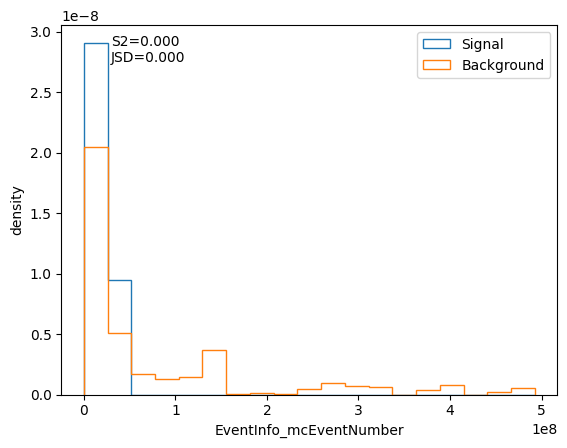

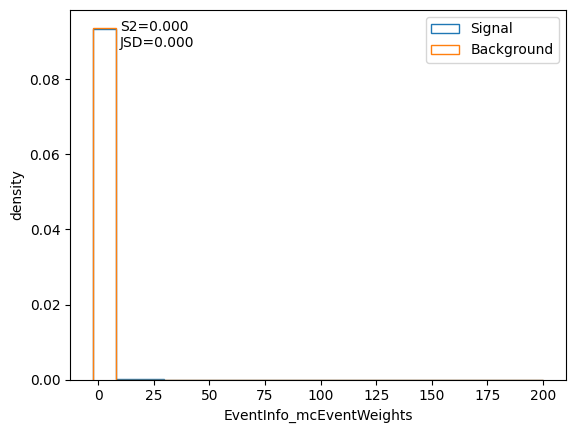

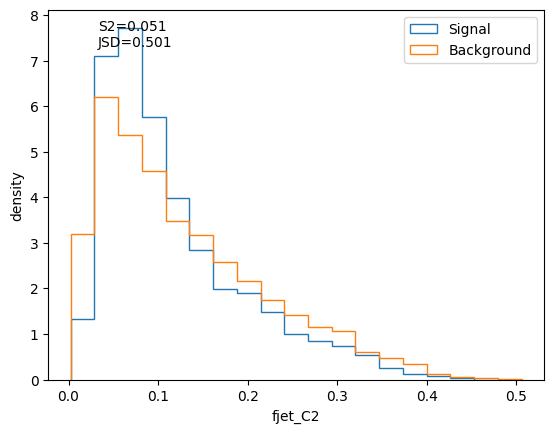

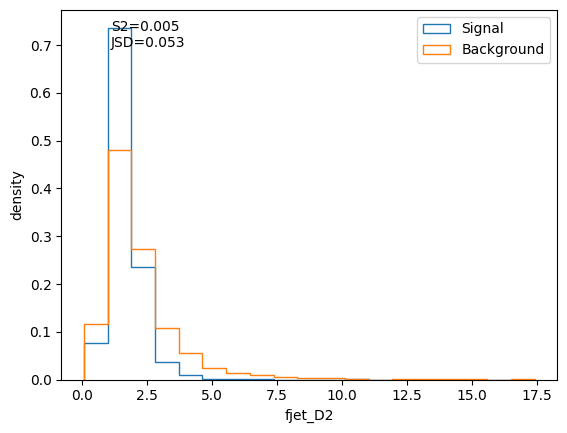

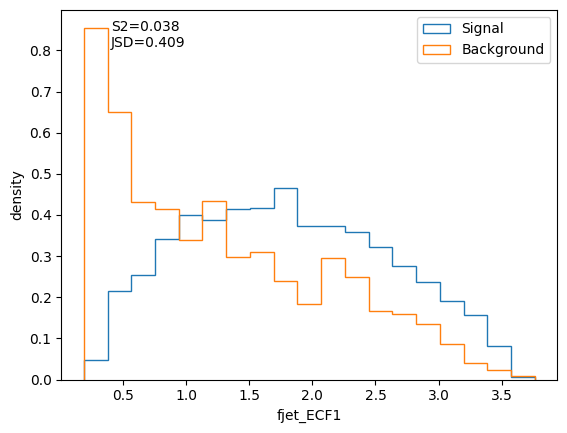

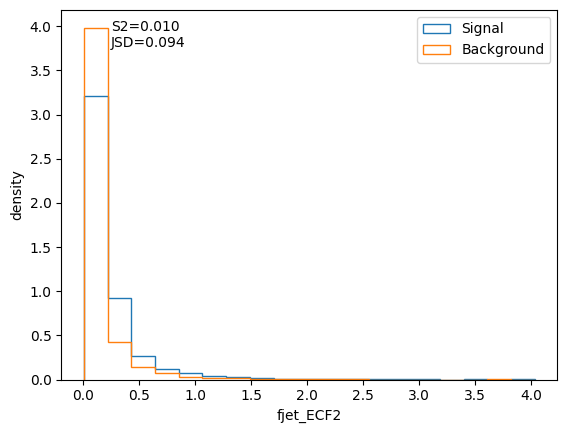

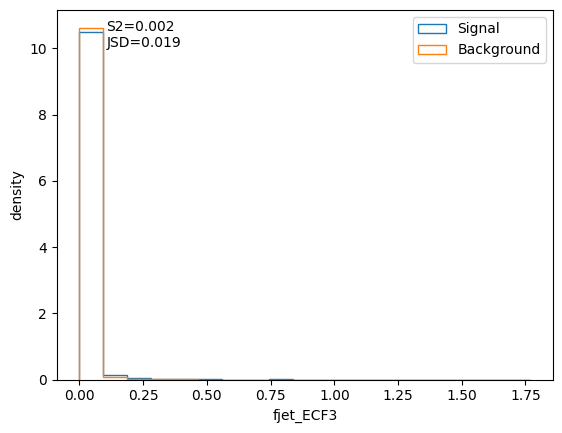

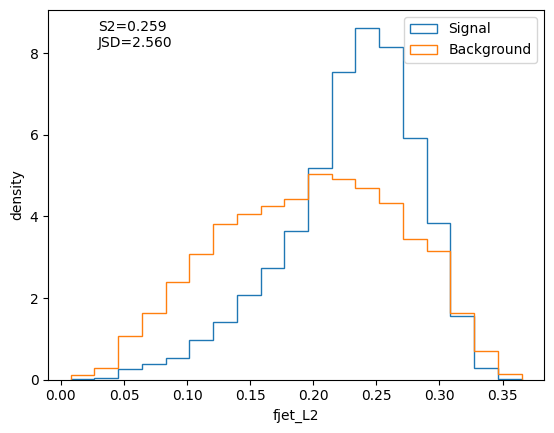

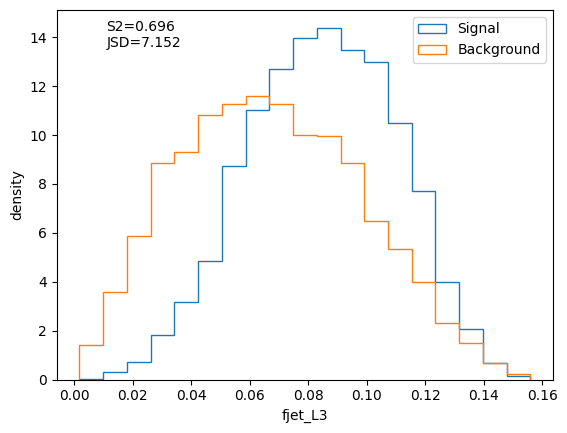

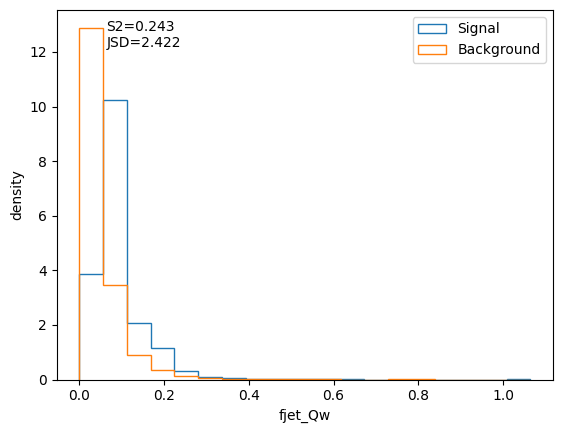

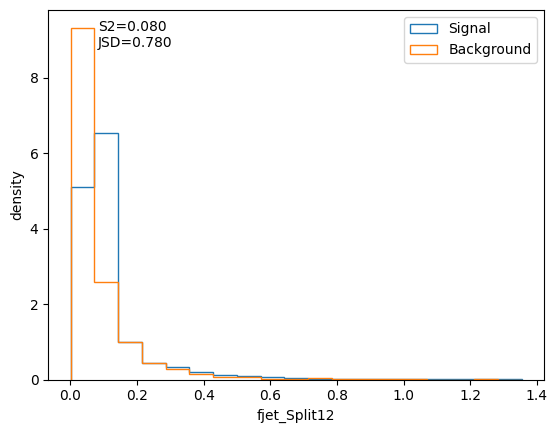

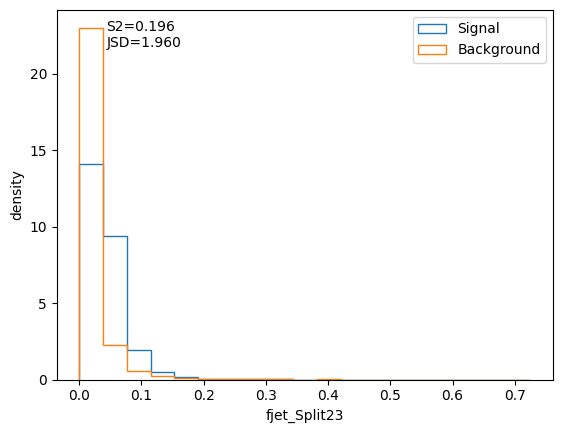

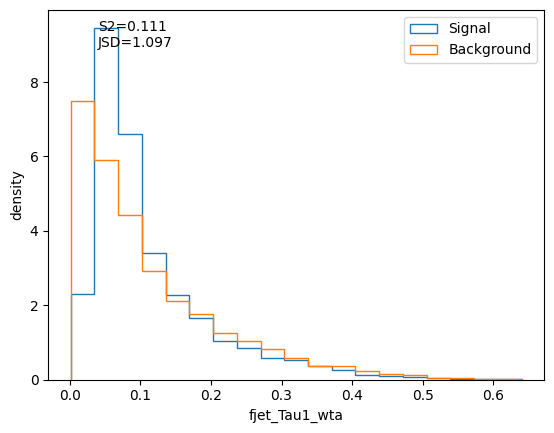

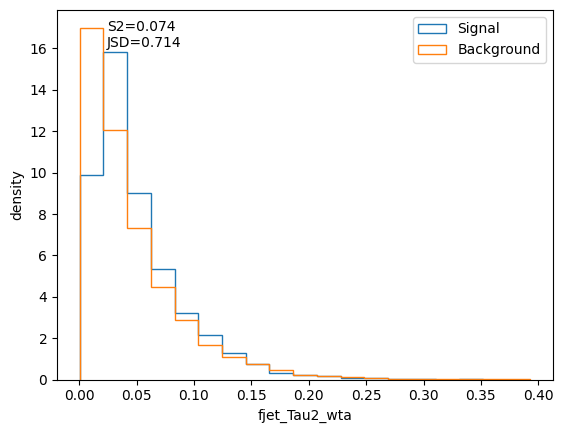

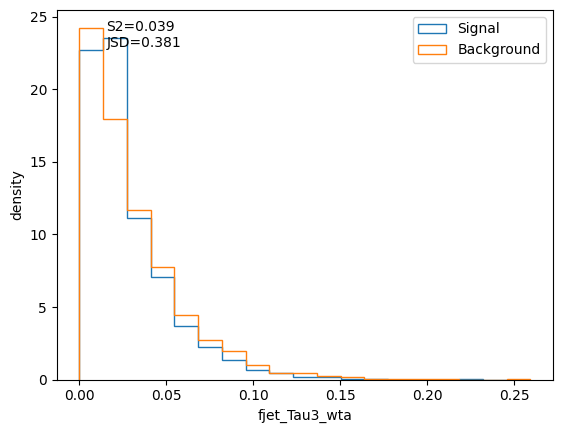

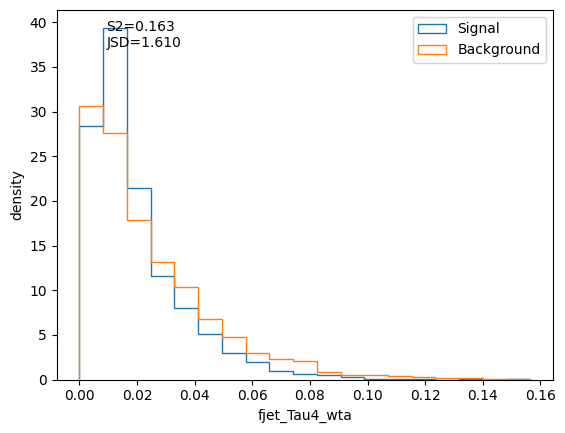

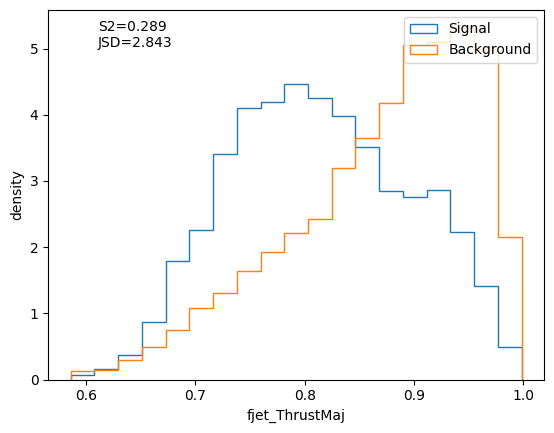

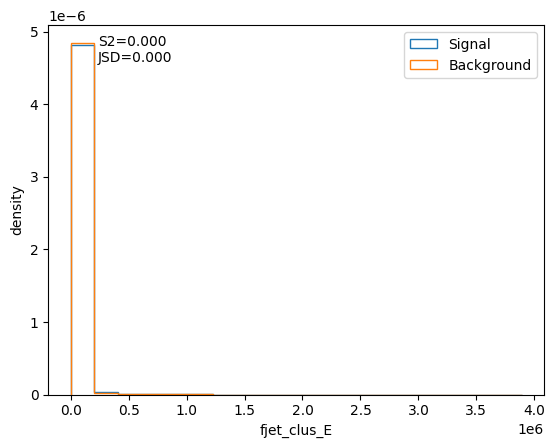

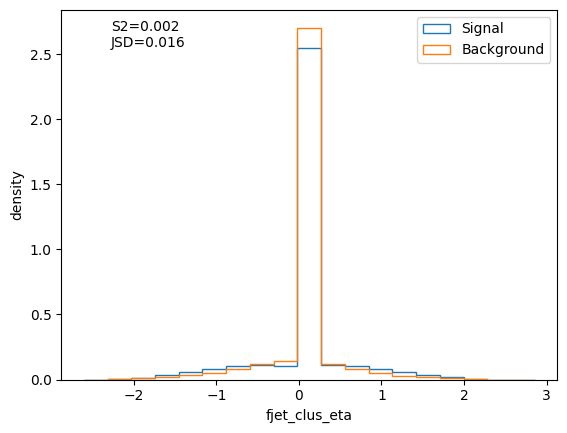

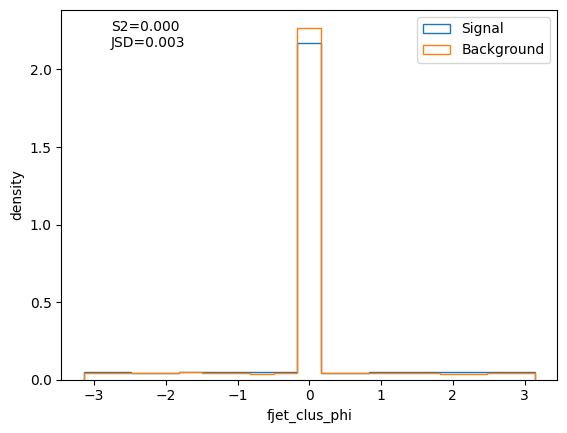

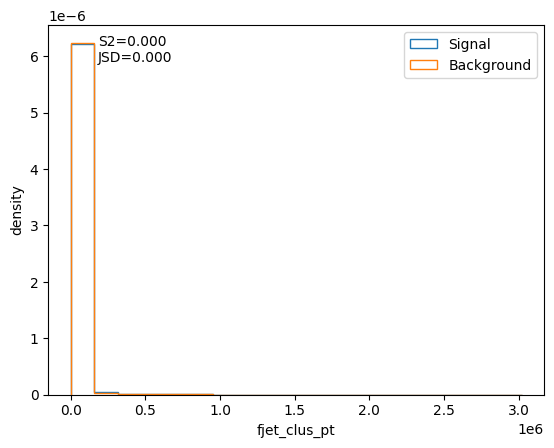

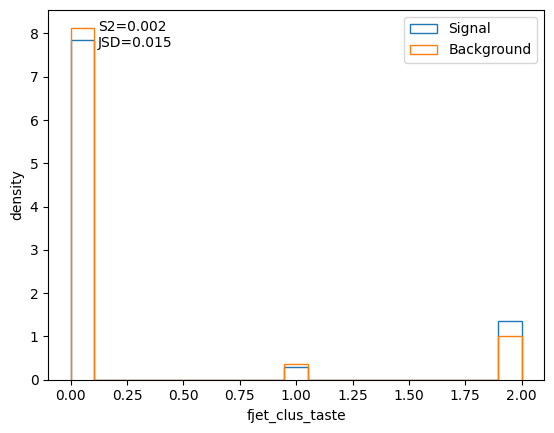

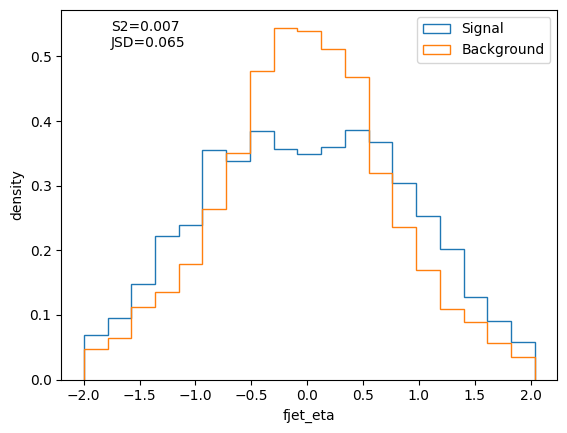

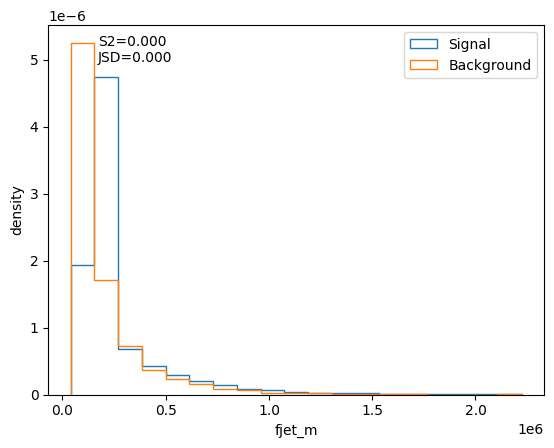

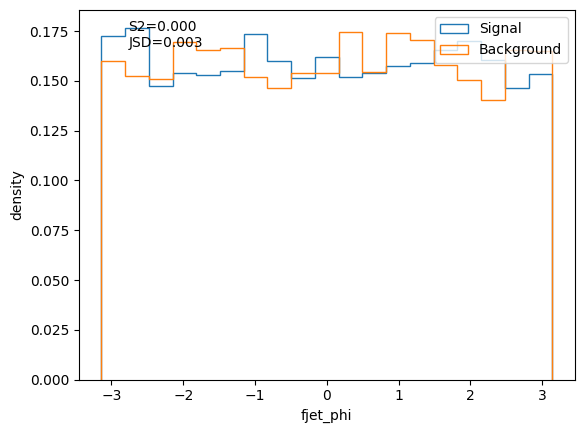

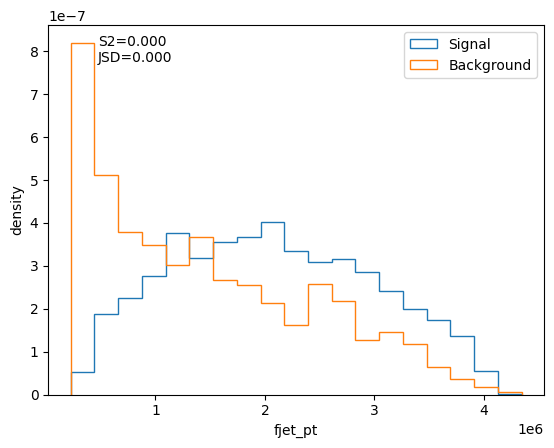

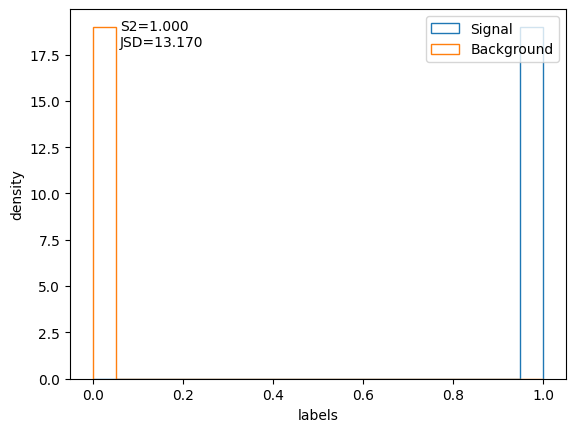

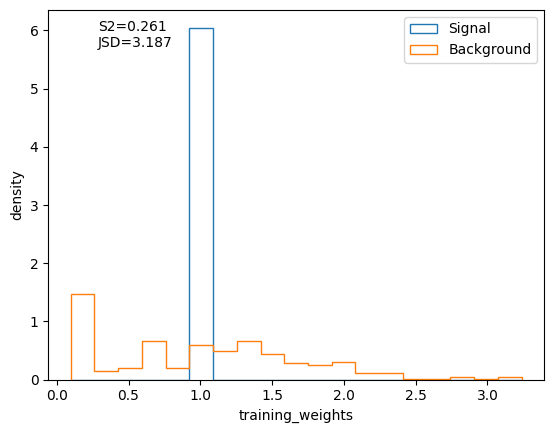

In [8]:
for var in f.keys():
    print(var)
    
    #some arrays to store the info
    values_sig=[]
    values_bkg=[]
    
    # loop over the labels
    for index,label in enumerate(labels): 
        if label==1:
            values_sig.append(f[var][index]) #Access the info on the jet at this index, can return a single value or array
        if label==0:
            values_bkg.append(f[var][index])
    
    #Some of the observables are constituent level so return an array, let's flatten them out into a 1D array for simplicitiy
    values_sig=np.asarray(values_sig).flatten()
    values_bkg=np.asarray(values_bkg).flatten()
    
    #make the histograms
    make_hist(values_sig, values_bkg, var)

## Other considerations of the inputs

Very fun! You may note the consitutents variables, stored as `fjet_clus_*` have many 0 entries. This is since the files are zero-padded up to 200 consitutents. Note also the constituents are $p_T$ ordered

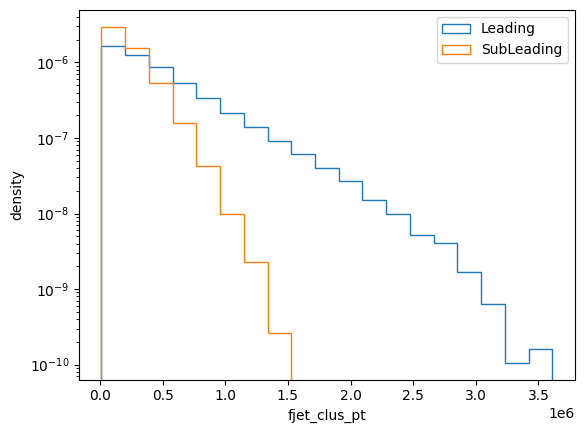

In [9]:
#Get the first and second cluster pt
first_const_pt=f["fjet_clus_pt"][:,0]
second_const_pt=f["fjet_clus_pt"][:,1]

#plot them
fig, ax = plt.subplots()
bins=np.linspace(min(first_const_pt),max(first_const_pt),20)
ax.hist(first_const_pt,bins=bins,histtype="step",density=True,label='Leading')
ax.hist(second_const_pt,bins=bins,histtype="step",density=True,label='SubLeading')
ax.set_yscale('log')
plt.xlabel("fjet_clus_pt")
plt.ylabel('density')
plt.legend()


You may have seen there were also training weights provided in the input. This is to support a common feature of tagging development where you want your tagger performance to be decorrelated with respect to some input observable, here the jet $p_T$. If you apply the training weights, then the pt distributions of the background will be reweighted to that of the signal, as can be seen below 

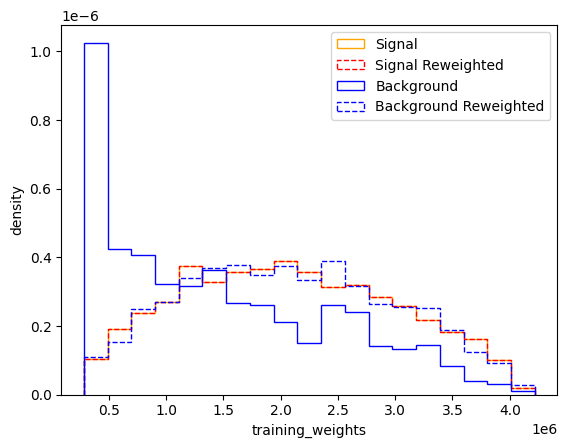

In [10]:
#Let's do this again for just the jet pt and training weights
values_sig=[]
values_bkg=[]
weights_sig=[]
weights_bkg=[]
for index,label in enumerate(labels):
    if label==1:
        values_sig.append(f["fjet_pt"][index])
        weights_sig.append(f["training_weights"][index])
    if label==0:
        values_bkg.append(f["fjet_pt"][index])
        weights_bkg.append(f["training_weights"][index])

#Now make a plot
fig, ax = plt.subplots()
bins=np.linspace(min(values_sig),max(values_sig),20)
ax.hist(values_sig,bins=bins,histtype="step",density=True,label='Signal',edgecolor='orange')
ax.hist(values_sig,bins=bins,histtype="step",density=True,label='Signal Reweighted',edgecolor='red',weights=weights_sig,linestyle='--')
ax.hist(values_bkg,bins=bins,histtype="step",density=True,label='Background',edgecolor='blue')
ax.hist(values_bkg,bins=bins,histtype="step",density=True,label='Background Reweighted',edgecolor='blue',weights=weights_bkg,linestyle='--')
plt.xlabel(name)
plt.ylabel('density')
plt.legend()